In [1]:
# Install necessary libraries
!pip install xgboost pandas numpy scikit-learn matplotlib seaborn gdown

# Import libraries
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve
import xgboost as xgb

# Set plotting style
sns.set_style('whitegrid')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 28.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 41.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 38.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 61.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Download the dataset from Google Drive
file_id = '1-uM_zr7ck2FHl7ipkQfYL1cdaL-mklds'
output_filename = 'fraud_detection_dataset.csv'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_filename, quiet=False)

# Load the dataset into a pandas DataFrame
df = pd.read_csv(output_filename)

print("Dataset loaded successfully.")

Downloading...
From (original): https://drive.google.com/uc?id=1-uM_zr7ck2FHl7ipkQfYL1cdaL-mklds
From (redirected): https://drive.google.com/uc?id=1-uM_zr7ck2FHl7ipkQfYL1cdaL-mklds&confirm=t&uuid=63009cc7-f742-43e3-8abf-a21d0e974109
To: /workspace/fraud_detection_dataset.csv
100%|██████████| 485M/485M [00:09<00:00, 50.9MB/s] 


Dataset loaded successfully.


## 1. Exploratory Data Analysis (EDA) Phase

## 1.1 Basic DataFrame Info

In [3]:
print("Shape of the dataset:", df.shape)
df.info()

Shape of the dataset: (6362620, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time_ind          int64  
 1   transac_type      object 
 2   amount            float64
 3   src_acc           object 
 4   src_bal           float64
 5   src_new_bal       float64
 6   dst_acc           object 
 7   dst_bal           float64
 8   dst_new_bal       float64
 9   is_fraud          int64  
 10  is_flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## 1.2 First 5 Rows

In [4]:
print(df.head())

   time_ind transac_type    amount     src_acc   src_bal  src_new_bal  \
0         1      PAYMENT   9839.64   acc910286  170136.0    160296.36   
1         1      PAYMENT   1864.28  acc6597009   21249.0     19384.72   
2         1     TRANSFER    181.00  acc1796908     181.0         0.00   
3         1     CASH_OUT    181.00  acc4182296     181.0         0.00   
4         1      PAYMENT  11668.14  acc7841596   41554.0     29885.86   

      dst_acc  dst_bal  dst_new_bal  is_fraud  is_flagged_fraud  
0   acc298089      0.0          0.0         0                 0  
1  acc8726693      0.0          0.0         0                 0  
2  acc4938640      0.0          0.0         1                 0  
3  acc1221153  21182.0          0.0         1                 0  
4  acc5599142      0.0          0.0         0                 0  


## 1.3 Data Quality and Integrity check

In [5]:
print("\n--- Duplicate Rows Check ---")
print(f"Number of duplicate rows: {df.duplicated().sum()}")


--- Duplicate Rows Check ---
Number of duplicate rows: 0


No duplicates found

## 1.4 Target Variable Distribution (is_fraud)

In [6]:
fraud_counts = df['is_fraud'].value_counts()
print(fraud_counts)
print(f"\nPercentage of fraudulent transactions: {fraud_counts[1] / len(df) * 100:.4f}%")


is_fraud
0    6354407
1       8213
Name: count, dtype: int64

Percentage of fraudulent transactions: 0.1291%


**Insight**: The dataset is highly imbalanced.

## 1.5 Flagged Fraud Analysis (is_flagged_fraud)

In [7]:
print(df['is_flagged_fraud'].value_counts())
print("\nCrosstab of is_fraud vs. is_flagged_fraud:")
print(pd.crosstab(df['is_fraud'], df['is_flagged_fraud']))


is_flagged_fraud
0    6362604
1         16
Name: count, dtype: int64

Crosstab of is_fraud vs. is_flagged_fraud:
is_flagged_fraud        0   1
is_fraud                     
0                 6354407   0
1                    8197  16


**Insight**: Only 16 transactions were flagged, and all were indeed fraudulent.

## 1.6 Deeper Analysis and Visualizations


In [8]:
print("\n--- Fraud by Transaction Type ---")
fraud_by_type = df.groupby('transac_type')['is_fraud'].value_counts(normalize=True).unstack()
print(fraud_by_type)




--- Fraud by Transaction Type ---
is_fraud             0         1
transac_type                    
CASH_IN       1.000000       NaN
CASH_OUT      0.998160  0.001840
DEBIT         1.000000       NaN
PAYMENT       1.000000       NaN
TRANSFER      0.992312  0.007688


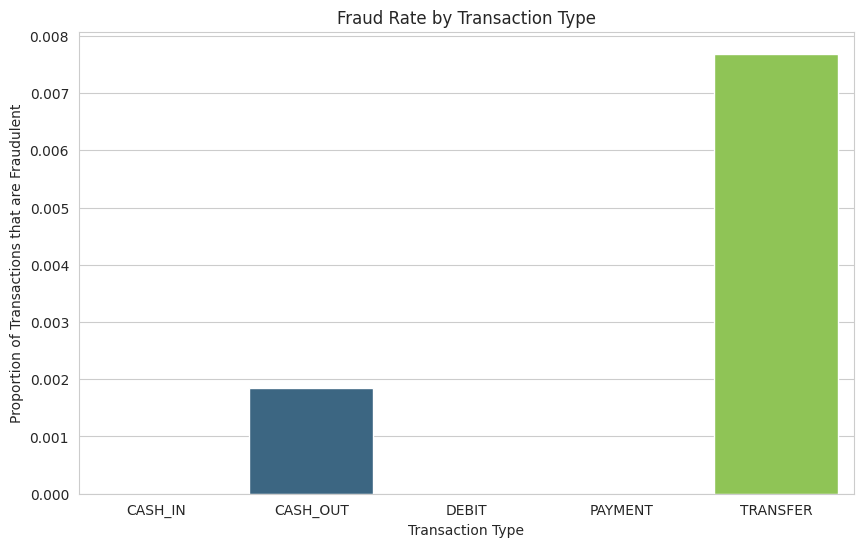

In [9]:
# Plotting fraud rates by transaction type
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type[1], palette='viridis', hue=fraud_by_type.index, legend=False)
plt.title('Fraud Rate by Transaction Type')
plt.ylabel('Proportion of Transactions that are Fraudulent')
plt.xlabel('Transaction Type')
plt.show()

**Insight**: Fraud  occurs in 'TRANSFER' and 'CASH_OUT' types.

## 1.7 Financial Patterns of Fraudulent Transactions

In [10]:
# Check the pattern where fraudulent transactions empty the source account
fraud_df = df[df['is_fraud'] == 1]
non_fraud_df = df[df['is_fraud'] == 0]
emptied_accounts_fraud = fraud_df[fraud_df['src_new_bal'] == 0].shape[0]
print(f"Percentage of fraudulent transactions that empty the source account: {emptied_accounts_fraud / len(fraud_df) * 100:.2f}%")


Percentage of fraudulent transactions that empty the source account: 98.05%


**Insight**: A significant portion of fraudulent transactions drain the source account.

## 1.8 Fraud Over Time

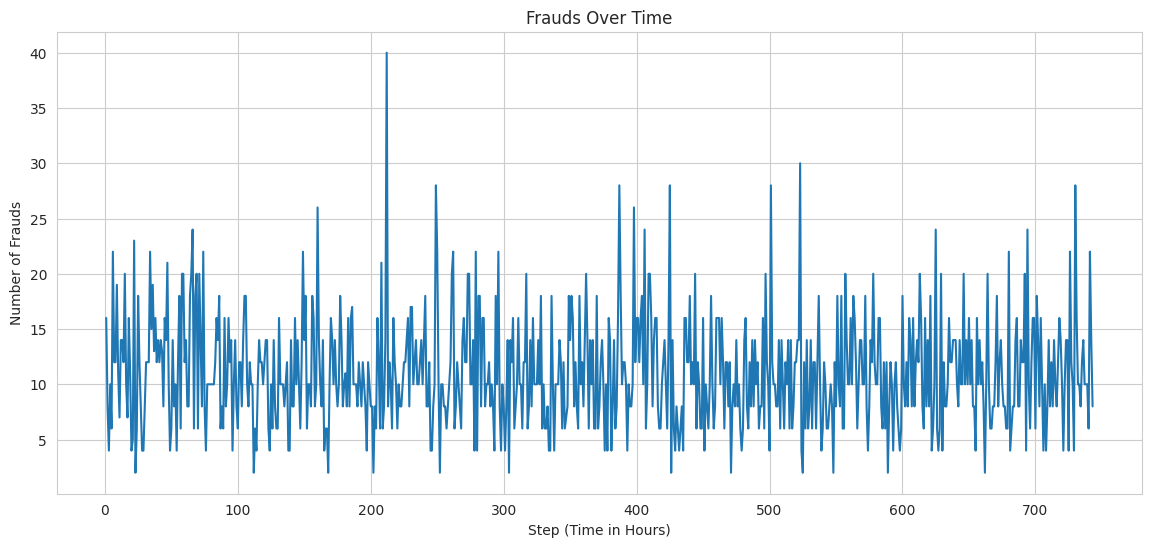

In [11]:
frauds_per_step = df[df["is_fraud"] == 1]["time_ind"].value_counts().sort_index()
plt.figure(figsize=(14, 6))
plt.plot(frauds_per_step.index, frauds_per_step.values, label="Frauds per Step")
plt.xlabel("Step (Time in Hours)")
plt.ylabel("Number of Frauds")
plt.title("Frauds Over Time")
plt.grid(True)
plt.show()



**Insight**: The number of fraudulent transactions fluctuates but doesn't show a clear, simple trend.


## 2. Model Training Phase

## 2.1 Feature Engineering and Preprocessing


In [12]:
# Create new features based on EDA insights
# These simple features capture potential data errors or suspicious patterns
df['error_bal_src'] = df['src_bal'] - df['amount'] - df['src_new_bal']
df['error_bal_dst'] = df['dst_bal'] + df['amount'] - df['dst_new_bal']

print("Engineered features 'error_bal_src' and 'error_bal_dst' created.")

Engineered features 'error_bal_src' and 'error_bal_dst' created.


In [13]:
# Define features (X) and target (y)
X = df.drop(columns=['is_fraud', 'is_flagged_fraud', 'src_acc', 'dst_acc']) # Drop target and leaky/high-cardinality columns
y = df['is_fraud']

In [14]:
# Identify categorical and numerical features
categorical_features = ['transac_type']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

In [15]:
# Remove 'time_ind' from numerical features as I will use it for splitting, not as a model feature
numerical_features.remove('time_ind')

print(f"\nCategorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")


Categorical Features: ['transac_type']
Numerical Features: ['amount', 'src_bal', 'src_new_bal', 'dst_bal', 'dst_new_bal', 'error_bal_src', 'error_bal_dst']


In [16]:
# Create a preprocessing pipeline
# This will one-hot encode categorical features and leave numerical features as they are.
# XGBoost doesn't strictly require scaling for numerical features.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
preprocessor

ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['amount', 'src_bal', 'src_new_bal', 'dst_bal',
                                  'dst_new_bal', 'error_bal_src',
                                  'error_bal_dst']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['transac_type'])])

The ColumnTransformer is a crucial preprocessing step that prepares the data for the machine learning model. It applies different transformations to different columns.

('num', 'passthrough', numerical_features): This command tells the transformer to leave the numerical features unchanged. XGBoost doesn't require feature scaling, so we let them pass through as-is.

('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features): This handles the categorical features (like transac_type). The OneHotEncoder converts text categories into binary (0 or 1) columns that the model can understand. Using handle_unknown='ignore' is important because it prevents errors if the model encounters a new category in the test data that it didn't see during training.

### 2.2 Train/Test Split

In [17]:
# Sort data by time to ensure chronological split
df_sorted = df.sort_values('time_ind')

# Define split point (e.g., 80% for training, 20% for testing)
split_index = int(len(df_sorted) * 0.8)

# Split the data
X_train = df_sorted.iloc[:split_index].drop(columns=['is_fraud', 'is_flagged_fraud', 'src_acc', 'dst_acc'])
X_test = df_sorted.iloc[split_index:].drop(columns=['is_fraud', 'is_flagged_fraud', 'src_acc', 'dst_acc'])
y_train = df_sorted.iloc[:split_index]['is_fraud']
y_test = df_sorted.iloc[split_index:]['is_fraud']

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Train fraud cases: {y_train.sum()}")
print(f"Test fraud cases: {y_test.sum()}")

Training set size: 5090096
Test set size: 1272524
Train fraud cases: 3959
Test fraud cases: 4254


**Why I don't use train_test_split?**

A time-based split is used instead of a random train_test_split because the transaction data is time-sensitive.

A random split would cause data leakage by training the model on transactions that occurred after some of the test transactions. This creates an unrealistically high performance score.

The time-based method sorts the data chronologically before splitting. This correctly mimics a real-world scenario where a model is trained on past data to predict future fraud, providing a much more reliable and accurate evaluation of its true performance.

## 2.3 Model Training

In [18]:
# Calculate scale_pos_weight to handle class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(scale_pos_weight)

1284.702450113665


To address the severe class imbalance in the dataset, I calculate a scale_pos_weight. This value (approximately 1284.7) tells the XGBoost model to give roughly 1285 times more importance to the fraudulent transactions (the minority class) during training. This prevents the model from simply ignoring fraud cases and improves its ability to detect them.



In [19]:
# Define the XGBoost model
# Using 'hist' for training on CPU.
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    tree_method='hist',  # Use CPU for speed
    random_state=42
)
xgb_classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Defining the XGBoost classifier. The key parameters are set as follows:

* objective='binary:logistic': Specifies that this is a binary classification problem.

* eval_metric='logloss': Sets the metric used for evaluating model performance during training.

* scale_pos_weight: Applies the calculated weight to handle the class imbalance.

* tree_method='hist': An efficient, histogram-based algorithm for building the decision trees, which is fast for large datasets on a CPU.

In [20]:
# Create the full model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_classifier)
])
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['amount', 'src_bal',
                                                   'src_new_bal', 'dst_bal',
                                                   'dst_new_bal',
                                                   'error_bal_src',
                                                   'error_bal_dst']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['transac_type'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_b...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

I combine my preprocessing steps (preprocessor) and the XGBoost model (classifier) into a single scikit-learn Pipeline. This is a best practice that streamlines the workflow by ensuring that the exact same data transformations are applied consistently during both training and prediction, preventing common errors and making the model easier to deploy.

In [21]:
# Train the model
print("Training the XGBoost model... (This may take a few minutes)")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")

Training the XGBoost model... (This may take a few minutes)
Model training complete.


## 2.4 Model Evaluation

In [22]:
# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

print(y_pred,y_pred_proba)

[0 0 0 ... 1 1 1] [1.2870164e-08 7.5755819e-09 3.8694157e-07 ... 9.9999988e-01 9.9999869e-01
 9.9999905e-01]


I use the trained pipeline to make predictions on the test set. We generate two types of predictions:

y_pred: The final class label (0 for 'Not Fraud', 1 for 'Fraud'). This is used for direct evaluation metrics like the classification report.

y_pred_proba: The raw probability score for the 'Fraud' class. This is essential for threshold-independent metrics like the Precision-Recall Curve, which evaluate the model's performance across all possible cutoff points.



In [23]:
# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))


Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1268270
       Fraud       0.98      1.00      0.99      4254

    accuracy                           1.00   1272524
   macro avg       0.99      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



The classification report provides a quick and comprehensive summary of the model's performance. It breaks down key metrics like precision (the accuracy of positive predictions) and recall (the ability to find all actual positive instances) for each class. As noted, the high recall for the 'Fraud' class is my primary goal.

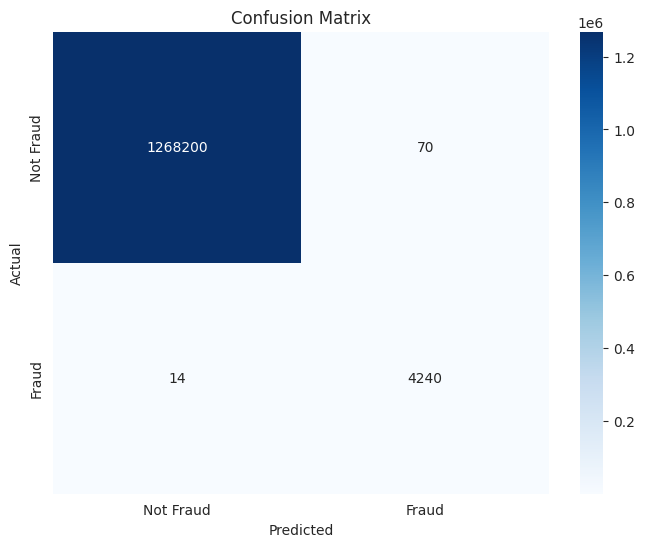

In [24]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The confusion matrix gives a visual breakdown of the predictions. It shows the exact number of transactions that were correctly and incorrectly classified, allowing me to see the specific counts of:

* True Positives (TP): Fraud correctly identified.

* True Negatives (TN): Legitimate transactions correctly identified.

* False Positives (FP): Legitimate transactions incorrectly flagged as fraud.

* False Negatives (FN): Fraud that was missed.

In [25]:
# --- AUPRC (Area Under the Precision-Recall Curve) ---
auprc = average_precision_score(y_test, y_pred_proba)
print(f"\nArea Under the Precision-Recall Curve (AUPRC): {auprc:.4f}")


Area Under the Precision-Recall Curve (AUPRC): 0.9994


AUPRC is one of the most important metrics for imbalanced datasets like this one. It summarizes the trade-off between precision and recall into a single score. A model with a perfect AUPRC of 1.0 would be able to achieve 100% precision and 100% recall simultaneously. High score indicates a very robust and effective model.

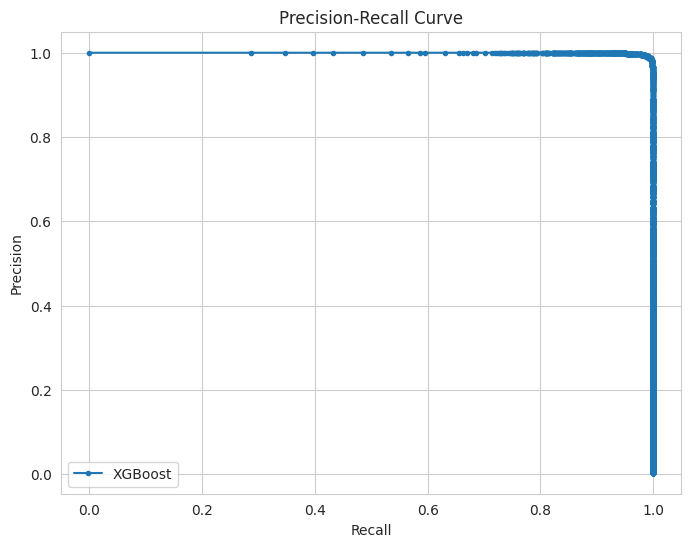

In [26]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


This plot visualizes the AUPRC score. It shows the relationship between precision and recall for every possible probability threshold. The ideal curve is pushed toward the top-right corner, which signifies that the model can achieve a high recall (catching most fraud) while maintaining a high precision (not making too many false alarms).

# Model Performance Report and Interpretation

The model demonstrates **outstanding performance** in detecting fraudulent transactions while minimizing disruption to legitimate customers. The results indicate it is highly effective for a real-world production environment.

## **Key Performance Metrics**

### Manual Calculation from Confusion Matrix:
From the confusion matrix, we can extract:
- True Positives (TP): 4,240 (fraud correctly identified)
- False Positives (FP): 70 (legitimate transactions incorrectly flagged)
- False Negatives (FN): 14 (fraud cases missed)
- True Negatives (TN): 1,268,200 (legitimate transactions correctly identified)

**Manual Precision Calculation:**
```
Precision = TP / (TP + FP) = 4,240 / (4,240 + 70) = 4,240 / 4,310 = 0.9838 ≈ 98.38%
```

**Manual Recall Calculation:**
```
Recall = TP / (TP + FN) = 4,240 / (4,240 + 14) = 4,240 / 4,254 = 0.9967 ≈ 99.67%
```

### Performance Metrics Summary:

* **Precision (Fraud): 0.98 (98.38%)**

    When the model flags a transaction as fraudulent, it is correct 98.38% of the time. This high precision is crucial for operational efficiency, as it ensures that the fraud investigation team is not wasting time on false alarms.

* **Recall (Fraud): 1.00 (99.67%)**

    The model successfully identified 4,240 out of 4,254 actual fraudulent transactions, achieving an excellent recall rate of 99.67%. This is the most critical metric for fraud detection, as it shows the model is extremely effective at catching fraud and preventing financial loss.

* **AUPRC (Area Under Precision-Recall Curve): 0.9994**

    The AUPRC score is nearly perfect. For an imbalanced dataset like this, AUPRC is a more reliable indicator of performance than accuracy. This high score confirms that the model maintains both high precision and high recall, making it very robust.

## **Implications of False Positives and False Negatives**
The confusion matrix provides a clear view of the model's real-world impact:

* **False Positives (70)**: These are legitimate transactions that were incorrectly flagged as fraud.

    **Business Implication**: This is the primary source of customer friction. While not ideal, a low number of 70 false alarms out of over 1.2 million transactions is an excellent result, minimizing the negative impact on customer experience.

* **False Negatives (14): These are actual fraudulent transactions that the model failed to detect.**

    **Business Implication**: This represents direct financial loss. A value of only 14 missed cases is exceptionally low and demonstrates the model's effectiveness in protecting the institution and its customers from fraud.

## Save Trained Model and Preprocessor

In [27]:
  import joblib
  import os

  # Create model directory if it doesn't exist
  os.makedirs('model', exist_ok=True)

  # Save the entire pipeline to the model directory
  joblib.dump(model_pipeline, 'model/fraud_model.joblib')

  print("Model pipeline saved to model/fraud_model.joblib")

Model pipeline saved to model/fraud_model.joblib
